In [1]:
from pybedtools import BedTool
import pandas as pd

def unique_str(x):
    x = set(x.split(';'))
    if not len(x) > 1:
        return x.pop()
    
    else:
        # print('ambiguous', ';'.join(x))
        return 'ambiguous'

def process_txn(txn):
    txn.loc[:, 'chr'] = txn.chr.apply(unique_str)
    txn.loc[:, 'strand'] = txn.strand.apply(unique_str)
    txn.loc[:, 'start'] = txn.start.apply(
        lambda x: min(int(i) for i in x.split(';'))
    )
    txn.loc[:, 'end'] = txn.end.apply(
        lambda x: max(int(i) for i in x.split(';'))
    )
    return txn

genes = pd.read_csv(
    '/groups/pavri/bioinfo/mihaela/RNASeq/count/CH12_RNASeq.count',
    sep = '\t',
    comment = '#'
)
genes.columns = ['gene_name', 'chr', 'start', 'end', 'strand', 'length'] + genes.columns[6:].to_list() 
genes = process_txn(genes)
genes = genes.drop(
    index = genes[genes.chr.str.startswith('ambiguous')].index
)
genes = genes.loc[genes.chr.str.startswith('chr'), ['chr', 'start', 'end', 'gene_name']]
genes = genes.sort_values(by = ['chr', 'start', 'end'])
genes

,chr,start,end,gene_name
20773,chr1,3204563,3661579,Xkr4
4846,chr1,4109947,4399322,Rp1
11156,chr1,4481009,4487435,Sox17
3313,chr1,4763279,4775807,Mrpl15
15883,chr1,4797904,4836816,Lypla1
...,...,...,...,...
1828,chrY_random,29419583,38091071,Gm20858
22229,chrY_random,31138726,54491766,Gm21292
14599,chrY_random,32818621,53820453,Gm20806
3381,chrY_random,54420149,54423069,Gm20815


In [2]:
frame_rows = []
for _, row in genes.iterrows():
    tss = [row.chr, row.start - 1000, row.start + 1000, 'TSS', row.gene_name]
    frame_rows.append(tss)
    if row.end - row.start > 1000:
        gene_body = [row.chr, row.start + 1000, row.end, 'gene_body', row.gene_name]
        frame_rows.append(gene_body)

    
genomic_regions = pd.DataFrame(
    frame_rows,
    columns = ['chr', 'start', 'end', 'regions', 'gene_name']
)
genomic_regions

,chr,start,end,regions,gene_name
0,chr1,3203563,3205563,TSS,Xkr4
1,chr1,3205563,3661579,gene_body,Xkr4
2,chr1,4108947,4110947,TSS,Rp1
3,chr1,4110947,4399322,gene_body,Rp1
4,chr1,4480009,4482009,TSS,Sox17
...,...,...,...,...,...
47883,chrY_random,32819621,53820453,gene_body,Gm20806
47884,chrY_random,54419149,54421149,TSS,Gm20815
47885,chrY_random,54421149,54423069,gene_body,Gm20815
47886,chrY_random,55232648,55234648,TSS,Gm21064


In [3]:
clustered_peaks = {}

clustered_peaks['priB'] = pd.read_csv(
    '../daniel/analysispriB/rif1/rif1_IgG1_heatmap_clustered_k3.bed',
    usecols = [0, 1, 2, 12],
    sep = '\t',
    skiprows = 1,
    names = ['chrom', 'start', 'end', 'cluster']
)

clustered_peaks['MEF'] = pd.read_csv(
    '../daniel/analysisMEF/rif1/rif1_heatmap_sortedi_k3.bed',
    usecols = [0, 1, 2, 12],
    sep = '\t',
    skiprows = 1,
    names = ['chrom', 'start', 'end', 'cluster']
)

clustered_peaks

{'priB':        chrom      start        end    cluster
 0      chr16   90141690   90146450  cluster_1
 1       chr2   98506231   98507652  cluster_1
 2       chr2   98505029   98505534  cluster_1
 3       chr1   64781211   64786053  cluster_1
 4       chr7  121704009  121708123  cluster_1
 ...      ...        ...        ...        ...
 16327   chrY    1600000    1820000  cluster_3
 16328  chr17    6228000    6534000  cluster_3
 16329  chr10  116800000  118584000  cluster_3
 16330   chr3   68400000   68680000  cluster_3
 16331   chr5  140940000  141740000  cluster_3
 
 [16332 rows x 4 columns], 'MEF':       chrom     start       end    cluster
 0     chr11   3059470   3060104  cluster_1
 1     chr11   3076548   3078378  cluster_1
 2     chr11   3092461   3092812  cluster_1
 3     chr11   3068775   3069173  cluster_1
 4     chr14  28240265  28243465  cluster_1
 ...     ...       ...       ...        ...
 1189   chr1  17112000  20728000  cluster_3
 1190  chr12  24720000  24928000  cluster

In [4]:
genomic_bed = BedTool().from_dataframe(genomic_regions)

aggregated_peak_overlaps = {}
for k, df in clustered_peaks.items():
    a = BedTool().from_dataframe(df)
    olap = a.intersect(
        genomic_bed,
        wo = True
    ).to_dataframe(
        names = df.columns.to_list() + ['chrom1', 'start1', 'end1'] + genomic_regions.columns[3:].to_list() + ['olap']
    )

    intergenic = a.subtract(genomic_bed).to_dataframe(
        names = df.columns.to_list()
    )

    intergenic['chrom1'] = intergenic['chrom']
    intergenic['start1'] = intergenic['start']
    intergenic['end1'] = intergenic['end']
    intergenic['regions'] = 'intergenic'
    intergenic['gene_name'] = '.'
    intergenic['olap'] = intergenic.end - intergenic.start

    df = pd.concat([olap, intergenic])
    agg = df.groupby(['cluster', 'regions']).agg({'olap': 'sum'}).reset_index()
    for cluster in agg.cluster.unique():
        agg.loc[agg.cluster == cluster, 'olap'] = agg.loc[agg.cluster == cluster, 'olap'] / agg.loc[agg.cluster == cluster, 'olap'].sum() * 100

    aggregated_peak_overlaps[k] = agg

aggregated_peak_overlaps

{'priB':      cluster     regions       olap
 0  cluster_1         TSS  31.718747
 1  cluster_1   gene_body  46.866752
 2  cluster_1  intergenic  21.414501
 3  cluster_2         TSS  10.831263
 4  cluster_2   gene_body  72.352276
 5  cluster_2  intergenic  16.816461
 6  cluster_3         TSS   5.352402
 7  cluster_3   gene_body  47.943398
 8  cluster_3  intergenic  46.704200,
 'MEF':      cluster     regions       olap
 0  cluster_1         TSS  35.192849
 1  cluster_1   gene_body  48.167196
 2  cluster_1  intergenic  16.639956
 3  cluster_2         TSS  26.735256
 4  cluster_2   gene_body  44.241868
 5  cluster_2  intergenic  29.022876
 6  cluster_3         TSS   0.770942
 7  cluster_3   gene_body  29.730136
 8  cluster_3  intergenic  69.498921}

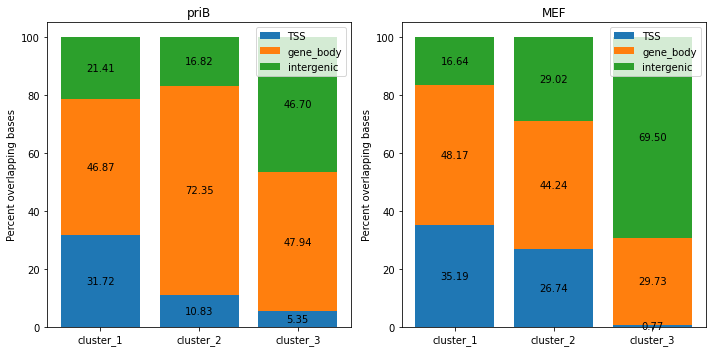

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

fig, axs = plt.subplots(1, 2)
for ax, (k, data) in zip(axs, aggregated_peak_overlaps.items()):
    heights = np.zeros(shape = 3)
    x = [0, 1, 2]
    for olap_type, zorder in zip(['TSS', 'gene_body', 'intergenic'], range(3, 0, -1)):
        feature_data = data.loc[
            (data.regions == olap_type), 
            ['olap', 'cluster']

        ].sort_values(
            by = 'cluster'
        )

        text_pos = heights.copy()
        heights += feature_data.olap.values
        text_pos = (text_pos + heights) / 2

        ax.bar(
            x = x,
            height = heights,
            zorder = zorder,
            label = olap_type
        )

        for pos_x, pos_y, height in zip(x, text_pos, feature_data.olap.values):
            ax.text(
                pos_x,
                pos_y,
                '{:.2f}'.format(height),
                ha = 'center',
                va = 'center'
            )

    ax.legend()
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['cluster_1', 'cluster_2', 'cluster_3'])

    ax.set_ylabel('Percent overlapping bases')
    ax.set_title(k)
    
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('percent_overlapping_bases_rifpeaks_clustered.pdf')